In [15]:
import os
import torch
from pathlib import Path
import mediapy
import matplotlib
from typing import Tuple, Optional, List, Dict, Any, Union
# Set working directory to the base directory 'gpudrive'
working_dir = Path.cwd()
while working_dir.name != 'gpudrive':
    working_dir = working_dir.parent
    if working_dir == Path.home():
        raise FileNotFoundError("Base directory 'gpudrive' not found")
os.chdir(working_dir)

from pygpudrive.env.config import EnvConfig, RenderConfig, SceneConfig
from pygpudrive.env.env_torch import GPUDriveTorchEnv


In [16]:
DYNAMICS_MODEL = "delta_local" # "delta_local" / "state" / "classic"
DATA_PATH = "data/processed/examples" # Your data path
MAX_NUM_OBJECTS = 32
NUM_ENVS = 1

# Configs
render_config = RenderConfig(draw_obj_idx=True)
scene_config = SceneConfig(path=DATA_PATH, num_scenes=NUM_ENVS)
env_config = EnvConfig(dynamics_model=DYNAMICS_MODEL)

In [17]:
env = GPUDriveTorchEnv(
    config=env_config,
    scene_config=scene_config,
    max_cont_agents=MAX_NUM_OBJECTS,
    device="cpu",
    render_config=render_config,
    action_type="continuous" # "continuous" or "discrete"
)


--- Ratio unique scenes / number of worls = 1 / 1 ---



In [18]:
expert_actions, _, _, _ = env.get_expert_actions()

expert_actions.shape


torch.Size([1, 32, 91, 3])

In [19]:
from pygpudrive.datatypes.roadgraph import LocalRoadGraphPoints

local_roadgraph = LocalRoadGraphPoints.from_tensor(
    local_roadgraph_tensor=env.sim.agent_roadmap_tensor(),
    backend="torch",
)

local_roadgraph

LocalRoadGraphPoints()

In [20]:
local_roadgraph.x.shape

torch.Size([1, 32, 256])

In [21]:
torch.where(env.cont_agent_mask[0, :])[0]

tensor([0, 1, 5])

In [22]:
from pygpudrive.datatypes.observation import (
    LocalEgoState,
    PartnerObs,
    LidarObs,
)
from pygpudrive.datatypes.trajectory import LogTrajectory
from pygpudrive.datatypes.roadgraph import LocalRoadGraphPoints


In [29]:
ego_state = LocalEgoState.from_tensor(
    self_obs_tensor=env.sim.self_observation_tensor(),
    backend="torch",
    device="cpu",
)

local_roadgraph = LocalRoadGraphPoints.from_tensor(
    local_roadgraph_tensor=env.sim.agent_roadmap_tensor(),
    backend="torch",
    device="cpu",
)

partner_obs = PartnerObs.from_tensor(
    partner_obs_tensor=env.sim.partner_observations_tensor(),
    backend="torch",
    device="cpu"
)

partner_obs.rel_pos_x.shape

torch.Size([1, 32, 31, 1])

In [30]:
local_roadgraph.x.shape

torch.Size([1, 32, 256])

In [31]:
ego_state.id.shape

torch.Size([1, 32])

In [32]:
ego_state.vehicle_length[0, 0].item()

4.623200416564941

In [33]:
%load_ext autoreload
%autoreload 2

from pygpudrive.visualize.core import plot_agent_observation

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


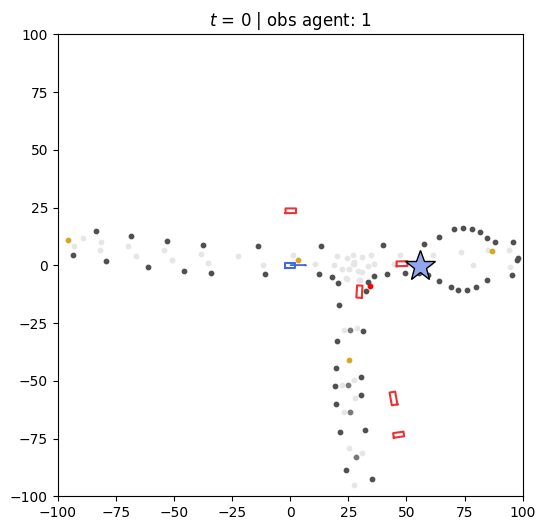

In [34]:
fig, ax = plot_agent_observation(
    env_idx=0,
    agent_idx=1,
    observation_roadgraph=local_roadgraph,
    observation_ego=ego_state,
    observation_partner=partner_obs,
    time_step=0,
);

In [61]:
import numpy as np
import matplotlib.pyplot as plt

def img_from_fig(fig: matplotlib.figure.Figure) -> np.ndarray:
  """Returns a [H, W, 3] uint8 np image from fig.canvas.tostring_rgb()."""
  # Just enough margin in the figure to display xticks and yticks.
  fig.subplots_adjust(
      left=0.08, bottom=0.08, right=0.98, top=0.9, wspace=0.05, hspace=0.05
  )
  fig.canvas.draw()
  data = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
  img = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))
  plt.close(fig)
  return img


In [62]:
mediapy.show_video([img_from_fig(fig)])

/tmp/ipykernel_751237/65554361.py:11: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed in 3.10. Use buffer_rgba instead.
  data = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)


In [53]:
# Reset environment
obs = env.reset()

expert_actions, _, _, _ = env.get_expert_actions()

frames = {f"env_{i}": [] for i in range(NUM_ENVS)}

# Step through the scene
for t in range(env_config.episode_len):

    env.step_dynamics(expert_actions[:, :, t, :])
    
    # Render the scenes
    for i in range(NUM_ENVS):
        frames[f"env_{i}"].append(env.render(i))

In [6]:
mediapy.show_videos(frames, fps=30, width=600, height=400, columns=1)

In [13]:
fig, ax = utils.init_fig_ax(viz_config)


NameError: name 'utils' is not defined